# Ground-Relative Sensitivity Plotting

##### Supplementary code for Faletti et al. (2026): _Using Ensemble Sensitivity to Diagnose Environmental Modulation of Mesocyclone Intensity in the Warn-on-Forecast System_

### Reproduces Fig. 4

In [1]:
import numpy as np
import xarray as xr
import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from wofunits import wofunits

# define mapping variables
shapefiles = wofunits.mapping['shapefiles']
shp_cols = wofunits.mapping['edgecolor']
shp_lws = wofunits.mapping['lw']

## Manually set case, time, etc. for the desired plotting

In [2]:
case = '201905172100'
state_time = datetime.datetime(2019,5,17,22,30)
resptime = datetime.datetime(2019, 5, 18, 0, 30)
statevars = ['T2','TD2'] # state variable list
respvar = 'UH-HRSWT25-WRF' # response variable 

sens_path = wofunits.paths['sens_path'] # sensitivity file path
wofs_path = wofunits.paths['wofs_path'] # WoFS data path

axlabels = ['a)','b)'] # axis labels

save = False # save plot?

## Plot Fig. 4: Ground-Relative Sensitivity Comparison Plots

/Volumes/faletti_backup/sens_out/sens_201905172100/stats_UH-HRSWT25-WRF_max_00_30_00_T2_22_30_00.nc
/Volumes/faletti_backup/sens_out/sens_201905172100/stats_UH-HRSWT25-WRF_max_00_30_00_TD2_22_30_00.nc


/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_6642/1921414671.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2.5)


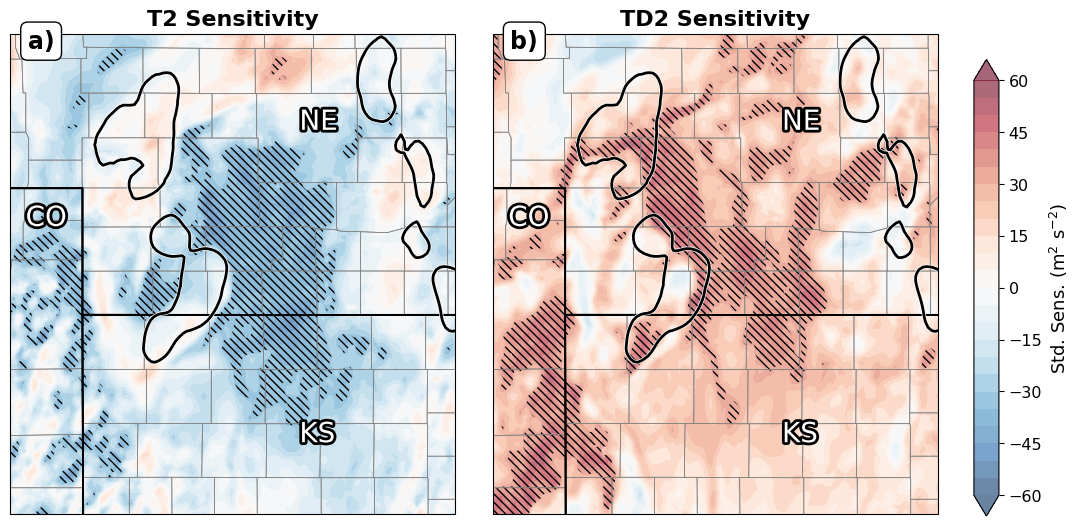

In [3]:

# Format time strings and define resp func/wofs datasets
statestr = str(state_time).replace('-','').replace(':','').replace(' ','')[:-2]
respstr = str(resptime).replace(':','_').replace(' ','_')
ds_resp = xr.open_dataset(f'''{sens_path}/sens_{case}/resp_{respvar.replace('-','_')}_max_{respstr}.nc''')
ds_wofs_gr = xr.open_dataset(f'{wofs_path}/wofs_{case[:8]}_{case[8:]}/wofs_i{case}_v{statestr}.nc')


# Plot
fig, axs = plt.subplots(1,2,figsize=(10,5.5), subplot_kw={'projection': ccrs.Mercator()})

ax1, ax2 = axs

axes = [ax1, ax2]   

for i, ax in enumerate(axes):
    
    statevar = statevars[i%2]
    
    file_sens_gr = f'{sens_path}/sens_{case}/stats_{respvar}_max_{str(resptime.hour).zfill(2)}_{str(resptime.minute).zfill(2)}_00_{statevar}_{str(state_time.hour).zfill(2)}_{str(state_time.minute).zfill(2)}_00.nc'
    ds_sens_gr = xr.open_dataset(file_sens_gr)
    print(file_sens_gr)
    
    lon = ds_sens_gr.XLONG
    lat = ds_sens_gr.XLAT
    sens = ds_sens_gr.stdsens
    pstat = abs(ds_sens_gr.pstat)
    
    cb = ax.contourf(lon, lat, sens, transform=ccrs.PlateCarree(),
                     cmap='RdBu_r', extend='both', levels=np.arange(-60,61,5), 
                      alpha=0.6, antialiased=True)

    ax.contourf(lon, lat, pstat, [0, 0.05], colors='none', hatches=['\\\\\\\\'], extend='lower',
                   transform=ccrs.PlateCarree())
    
    ax.contour(lon, lat, np.nanmean(ds_wofs_gr.REFD_MAX, axis=(0,1)), colors='w', levels=[20,999],
                        linewidths=3, transform=ccrs.PlateCarree())
    ax.contour(lon, lat, np.nanmean(ds_wofs_gr.REFD_MAX, axis=(0,1)), colors='k', levels=[20,999],
                        linewidths=2, transform=ccrs.PlateCarree())
    
    ax.set_title(f'{statevar} Sensitivity', size=16, weight='bold')
        
for i, ax in enumerate(axes):
    for j in range(len(shapefiles)):
        #if j == 0:
        #    continue
        reader = shpreader.Reader(shapefiles[j])
        vector_data = list(reader.geometries()) 
        VECTOR_DATA = cfeature.ShapelyFeature(vector_data, ccrs.PlateCarree())
        ax.add_feature(VECTOR_DATA, facecolor='none', edgecolor = shp_cols[j], lw = shp_lws[j])
    
    ax.set_extent([-102.8, -98.2, 38.4, 42.2], crs=ccrs.PlateCarree())

    ax.annotate(text=axlabels[i], xy=(0.04, 0.97), bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), 
                size = 17, weight='bold', xycoords='axes fraction')
    
    resp_box = mpatches.Rectangle(xy=(ds_resp.attrs['RF_CENTER_LON']+ds_resp.attrs['RF_X_LEFT'],
                                ds_resp.attrs['RF_CENTER_LAT']+ds_resp.attrs['RF_Y_BOTTOM']),
                             width=abs(ds_resp.attrs['RF_X_LEFT'])*2, 
                             height=abs(ds_resp.attrs['RF_Y_BOTTOM'])*2,
                             ls='--', lw=3, edgecolor='k', facecolor='None', transform=ccrs.PlateCarree()) 
    
    #ax.add_patch(resp_box)
    
    ax.text(0.65, 0.15, 'KS', transform=ax.transAxes, size=20, color='w',
          path_effects=[pe.withStroke(linewidth=4, foreground='k')])
    ax.text(0.65, 0.8, 'NE', transform=ax.transAxes, size=20, color='w',
          path_effects=[pe.withStroke(linewidth=4, foreground='k')])
    ax.text(0.035, 0.6, 'CO', transform=ax.transAxes, size=20, color='w',
          path_effects=[pe.withStroke(linewidth=4, foreground='k')])

# colorbar
fig.subplots_adjust(0, 0, 0.8, 1)
cb_ax = fig.add_axes([1, 0.06, 0.025, 0.83])
cbar = fig.colorbar(cb, cax=cb_ax, pad=0.18, ticks=np.arange(-60,61,15))
cbar.set_label(label=f'Std. Sens. ({wofunits.labels[respvar]})', size=13)
cbar.ax.tick_params(labelsize=11.5)

plt.tight_layout(pad=2.5)

if save == True:
    plt.savefig(fname=f'{outplot_path}/gr_sens_2100utc_{case}.png', dpi=300, bbox_inches='tight', facecolor='w')
